In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import jax
import ticktack
from ticktack import fitting
from tqdm import tqdm
import emcee

import corner
rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_sine.csv')
cf.prepare_function(use_control_points=True, interp='gp')
cf.offset = 0

In [3]:
params = jnp.array([2.00967368, 1.83722005, 1.64131659, 1.53621338, 1.54956525,
       1.66283525, 1.82696321, 2.00391815, 2.14344128, 2.19709936,
       2.14684926, 2.00827427, 1.82531541, 1.65642762, 1.55562115,
       1.55525348, 1.65562488, 1.82481902, 2.00895719, 2.14935574,
       2.20119142, 2.14776001, 2.00581124, 1.82028481, 1.65001027,
       1.54909134, 1.54961388, 1.65149079, 1.82251794, 2.00851632,
       2.15057973, 2.20372406, 2.15117623, 2.00966834, 1.82418043,
       1.6536497 , 1.55222482, 1.55207972, 1.65320969, 1.82348198,
       2.00878203, 2.15020536, 2.20280941, 2.14981545, 2.00801343,
       1.82240925, 1.65185187, 1.55046371, 1.5504303 , 1.65178338,
       1.82232604, 2.00791393, 2.14964303, 2.20254582, 2.14988553,
       2.00837896, 1.82298691, 1.65263095, 1.55141962, 1.55149937,
       1.65286832, 1.82335548, 2.00883447, 2.15039692, 2.20306118,
       2.15007592, 2.00821152, 1.82244066, 1.65167066, 1.55005743,
       1.54980055, 1.65094448, 1.82131178, 2.00682247, 2.14862099,
       2.20176739, 2.1494566 , 2.00843379, 1.82361733, 1.65381228,
       1.55300543, 1.55320536, 1.65424806, 1.82381264, 2.00770239,
       2.147114  , 2.19746144, 2.14260138, 2.00020468, 1.81641772,
       1.65117851, 1.55888841, 1.57012058, 1.68018942, 1.84881622,
       2.00447377, 2.07130876, 2.05570146])

In [4]:
@jit
def neg_loss_chi2(params=()):
    d_14_c = cf.dc14(params=params)
    chi2 = jnp.sum(((cf.d14c_data[:-1] - d_14_c) / cf.d14c_data_error[:-1]) ** 2)
    chi2 += 5 * jnp.sum(((cf.d14c_data[:4] - d_14_c[:4]) / cf.d14c_data_error[:4]) ** 2)
    return -0.5*chi2

In [5]:
print("total likelihood: ", cf.gp_likelihood(params))
print("gp likelihood: ", cf.gp_neg_log_likelihood(params))
print("chi2: ", neg_loss_chi2(params))

total likelihood:  105.46776443336155
gp likelihood:  105.44799952618011
chi2:  -0.019764907181443078


In [6]:
initial = params
burnin, production = 500, 500
ndim, nwalkers = len(initial), 2*len(initial)
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_loss_chi2)

print("Running burn-in...")
p0 = initial + 1e-5 * np.random.rand(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, burnin, progress=True);

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [1:07:58<00:00,  8.16s/it]


In [7]:
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, production, skip_initial_state_check=True, progress=True);

Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [1:06:03<00:00,  7.93s/it]


In [8]:
# import pickle
# with open('sine_sampler.p', 'wb') as handle:
#     pickle.dump(sampler, handle)

In [9]:
mean = np.mean(sampler.flatchain, axis=0)

In [10]:
mean

array([2.0099254 , 1.81837665, 1.65311222, 1.57371749, 1.53635292,
       1.66273404, 1.76754014, 1.98660022, 2.2163825 , 2.205586  ,
       2.13530245, 2.03501194, 1.75706556, 1.69093455, 1.59616627,
       1.47345001, 1.68791683, 1.86997067, 2.05815286, 2.10499555,
       2.19267991, 2.1333797 , 2.01721519, 1.81433877, 1.65570734,
       1.54942159, 1.51435975, 1.72330501, 1.73845296, 2.04021112,
       2.13951205, 2.25408578, 2.16827091, 1.98981851, 1.7937762 ,
       1.63057199, 1.52168078, 1.56058774, 1.66886106, 1.81858446,
       2.06464048, 2.08734757, 2.1997719 , 2.1630009 , 2.04277047,
       1.74027505, 1.65418211, 1.60862898, 1.58517327, 1.5863865 ,
       1.82909186, 2.01819613, 2.16420565, 2.20891884, 2.16671858,
       1.9160366 , 1.79312953, 1.72324046, 1.62433406, 1.50496412,
       1.70313613, 1.72821374, 2.02618026, 2.12218486, 2.16447863,
       2.18277012, 2.07627226, 1.74494705, 1.68105503, 1.54692163,
       1.49283579, 1.6887007 , 1.83541754, 1.9200002 , 2.23866

In [11]:
std = np.std(sampler.flatchain, axis=0)

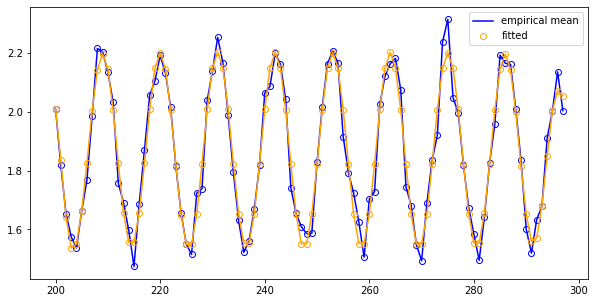

In [12]:
d14c = cf.dc14(params=mean)
d14c_fine = cf.dc14_fine(params=mean)
plt.plot(cf.control_points_time, mean, "bo", fillstyle="none")
plt.plot(cf.control_points_time, mean, color="b", label="empirical mean")
plt.plot(cf.control_points_time, params, 'o', color="orange", fillstyle="none", label="fitted")
plt.plot(cf.control_points_time, params, color="orange")
plt.legend()

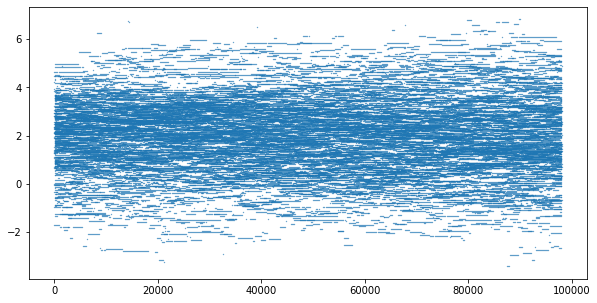

In [13]:
plt.plot(sampler.flatchain[:, 7], ".", markersize=0.6)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.28it/s]


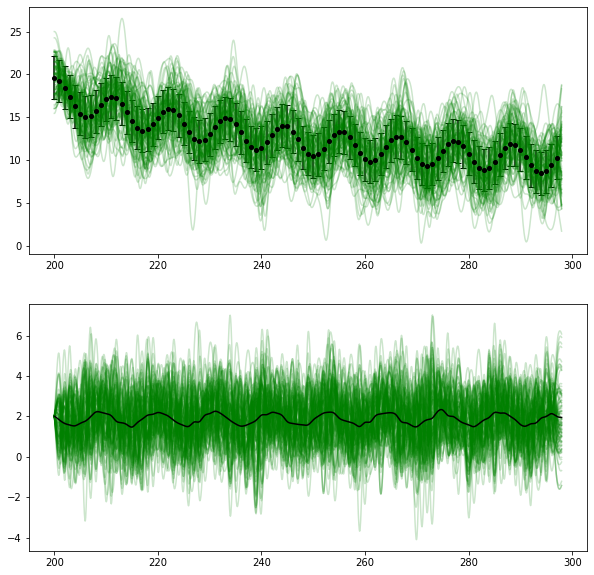

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
n = 100
top_n = np.random.permutation(len(sampler.flatchain))[:n]
ax1.errorbar(cf.time_data[:-1], cf.d14c_data[:-1], yerr=cf.d14c_data_error[:-1], 
             fmt="o", color="k", fillstyle="full", capsize=3, markersize=4)
for i in tqdm(top_n):
    d14c = cf.dc14_fine(params=sampler.flatchain[i, :])
    ax1.plot(cf.time_grid_fine, d14c, color="g", alpha=0.2)
    control_points_fine = cf.production(cf.time_grid_fine, (sampler.flatchain[i, :],))
    ax2.plot(cf.time_grid_fine, control_points_fine, color="g", alpha=0.2)
control_points_fine = cf.production(cf.time_grid_fine, (mean,))
ax2.plot(cf.time_grid_fine, control_points_fine, "k")

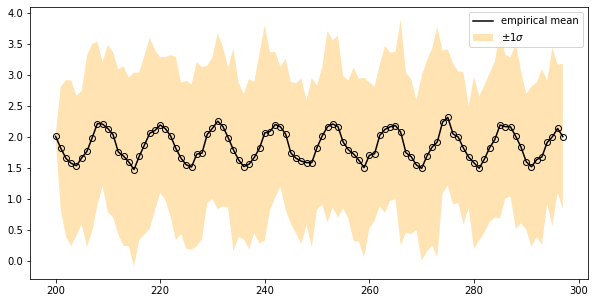

In [15]:
std = np.std(sampler.flatchain, axis=0)
plt.fill_between(cf.control_points_time, mean+std, mean-std, 
                 color='orange', alpha=0.3, edgecolor='none', label='$\pm 1\sigma$')
plt.plot(cf.control_points_time, mean, color="k", label="empirical mean")
plt.plot(cf.control_points_time, mean, "ko", fillstyle="none")
plt.legend()

In [16]:
std

array([0.01253569, 0.99366808, 1.26368656, 1.3380526 , 1.12539979,
       1.0763433 , 1.54237929, 1.51414002, 1.32036715, 1.00212557,
       1.34857436, 1.33135573, 1.33257599, 1.4491631 , 1.35961523,
       1.56274685, 1.35373589, 1.44286303, 1.54144378, 1.29526038,
       1.09547003, 1.1526123 , 1.30229675, 1.48048214, 1.22017775,
       1.35431072, 1.33199465, 1.48788043, 1.38732437, 1.10999166,
       1.14176534, 1.41720872, 1.2882666 , 1.12825489, 1.62952834,
       1.247474  , 1.17261199, 1.37292517, 1.22000862, 1.53422344,
       1.73567416, 1.27865424, 1.17309125, 0.9670428 , 1.21781638,
       1.14171101, 1.21455095, 1.3366785 , 1.00469456, 1.36247765,
       1.00018991, 1.111543  , 1.5427568 , 1.34934113, 1.4666159 ,
       1.06802408, 1.1167622 , 1.39821581, 1.31491351, 1.44945496,
       1.17979177, 1.08142063, 1.14612566, 1.34583135, 1.19520858,
       1.18956088, 1.8204508 , 1.29093328, 1.24827729, 1.05221484,
       1.48991501, 1.54121537, 1.58902536, 1.85938349, 1.15507

In [17]:
sample = sampler.flatchain[:, :10]

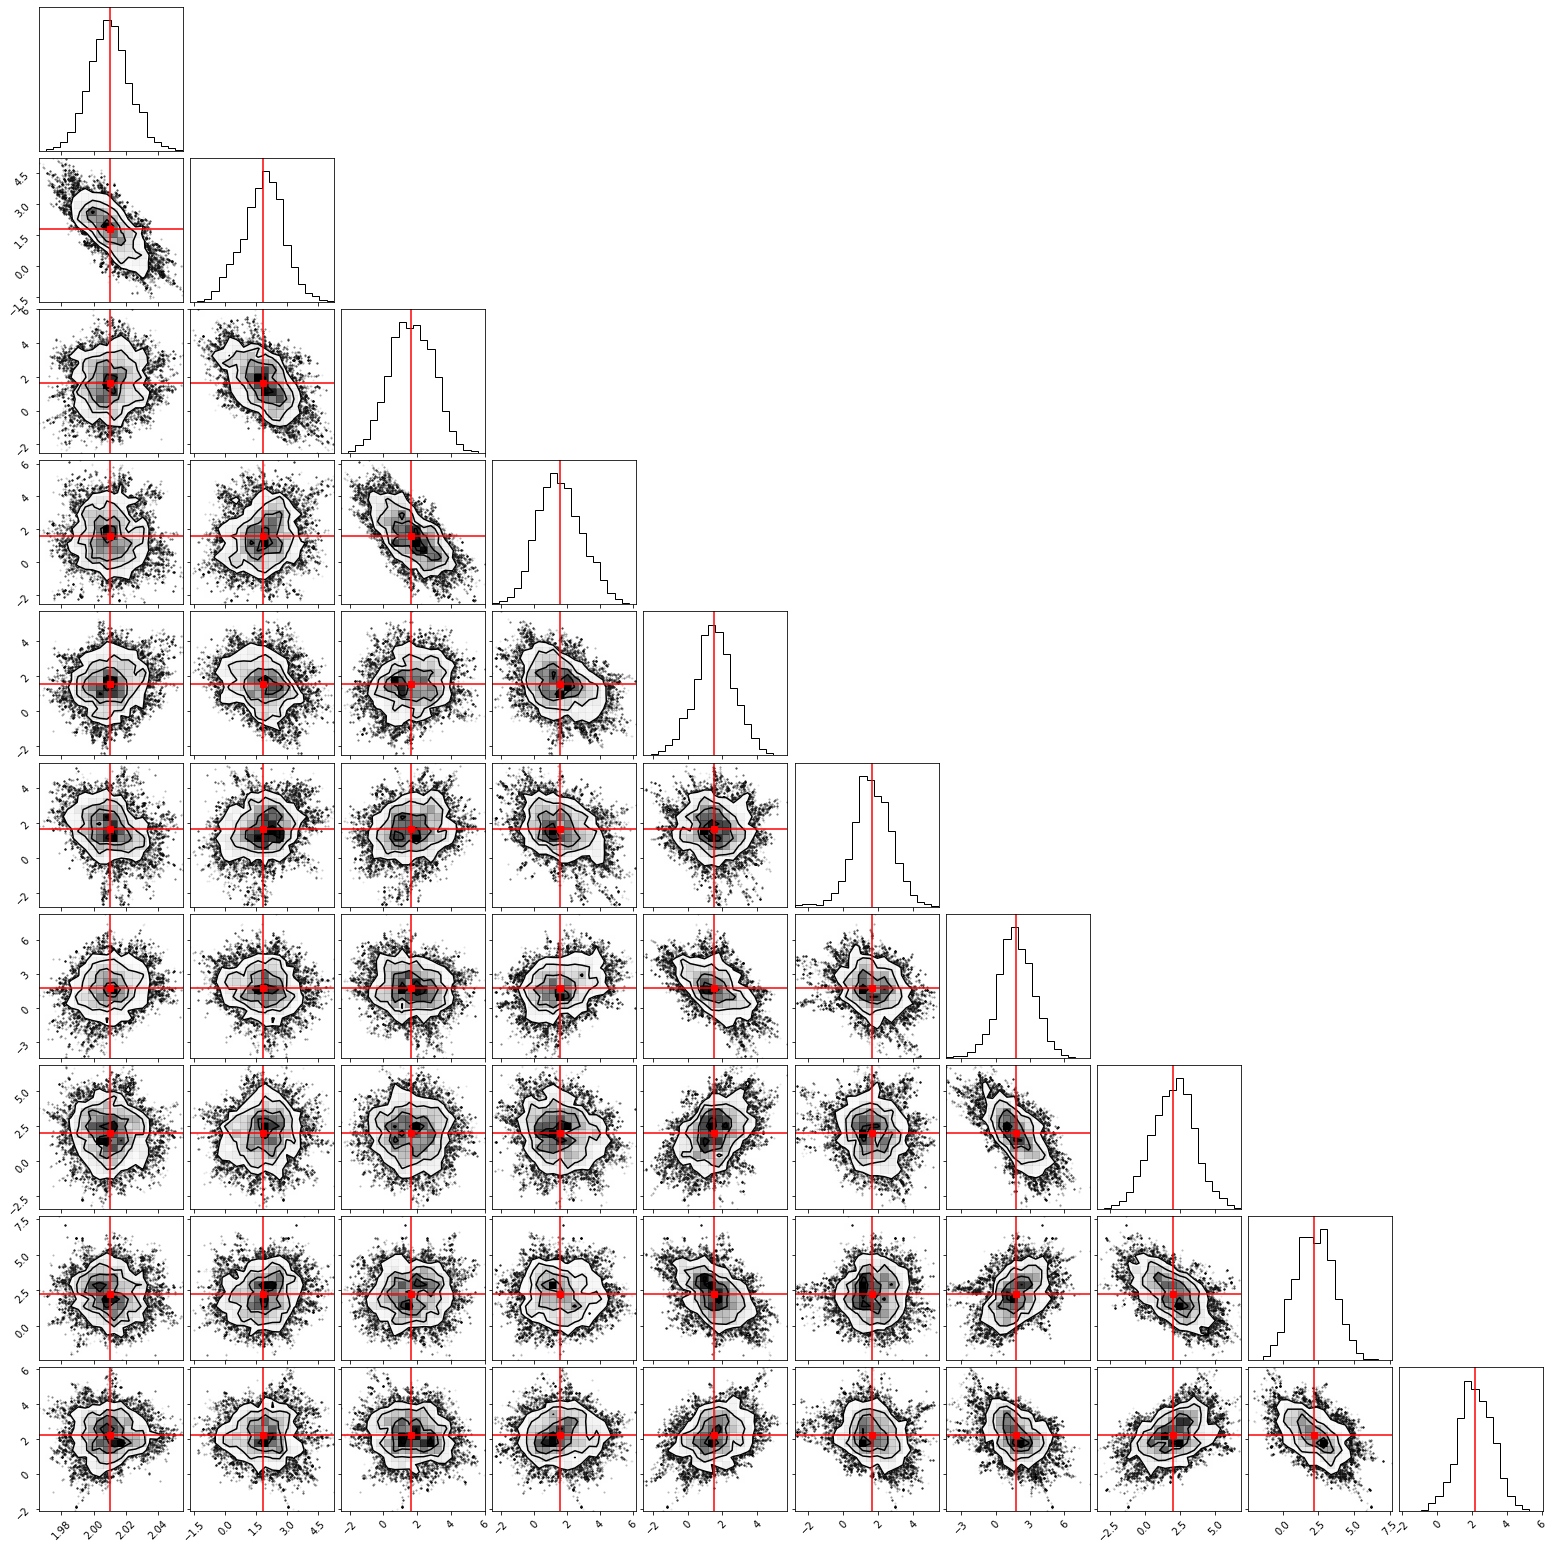

In [18]:
ndim = sample.shape[1]
figure = corner.corner(sample)
value = np.mean(sample, axis=0)
axes = np.array(figure.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value[i], color="r")

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value[xi], color="r")
        ax.axhline(value[yi], color="r")
        ax.plot(value[xi], value[yi], "sr")